# Simulating larger systems using Aer

In the other notebook we simulated a small, 2-qubit system. For larger systems we run into trouble. First of all, without special techniques it is generally not feasible to simulate systems larger 20-25 qubits on traditional hardware. Secondly, when using a backend with more than 65 qubits, the BasicSimulator will flatout refuse to run the simulation. 
When Aer is installed, this simulation backend is automatically used, so at least the second problem is solved. Aer will note that not all qubits are used, and optimize execution so only the required qubits are allocated and processed.
To install Aer use the folowing command (replace pipenv when using another environment management system)
```
pipenv install qiskit_aer
```
For more info about Aer, check the documentation: [Aer - Tutorials](https://qiskit.github.io/qiskit-aer/tutorials/index.html)


In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

First we'll build a [Greenberg-Horne-Zellinger](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) (GHZ) state. This is a state that consists of M subsystems that are maximally entangled. It can be seen as an extension of the Bell state from the previous example. GHZ states are of the following form when the subsystems are 2D qubits
\begin{align}
    |\text{GHZ}\rangle = \frac{ |0\rangle^{\otimes M} + |1\rangle^{\otimes M} }{\sqrt{2}}
\end{align}
Which reduces to the Bell state from the previous example when M=2.

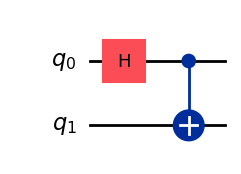

In [2]:
def get_qc_for_n_qubit_GHZ_state(M: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(M, int) and M >= 2:
        qc = QuantumCircuit(M)
        qc.h(0)
        for i in range(M - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc

# Show the circuit for M=2, which is identical to the circuit from the previous notebook
M = 2
qc = get_qc_for_n_qubit_GHZ_state(M)
qc.draw("mpl")

But the real experiment will be done on a circuit with 10 qubits.

In [3]:
M = 10
qc = get_qc_for_n_qubit_GHZ_state(M)

Then we need to define which operators we are interested in. In this experiment we will look at how correlated the state will be when qubits are physically separated in the system. On a simulator with perfect coherence the correlations will be ideal and the desired GHZ state is perfectly reproduced. But in reality the qubits will decohere, there will be noise and other physical reasons that the state can't be created perfectly.

This process is highly dependent on the exact nature of the chosen architecture. From the layout and interconnections of the physical qubits, to the subset of quantum operations that are available on the architecture. IBM allows the use of real hardware through their IBM Quantum Platform. But it is also possible to run local experiments using the physical backends as a basis. Aer is capable of taking noise profiles and giving back a physically insightful result, instead of the perfect simulation of [BasicSimulator](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.basic_provider.BasicSimulator).

Since we are now going to direcly interact with Aer we need to manage some of our measurement structure ourselves/ In this case it means that we have to take the size of the backend into consideration when designing our observables.

In [4]:
def build_operators(n, num_qubits_in_backend):    
    # ZZII...II, ZIZI...II, ... , ZIII...IZ
    operator_strings = [
        "Z" + "I" * i + "Z" + "I" * (n - 2 - i) + "I" * (num_qubits_in_backend - n) for i in range(n - 1)
    ]
    
    return [SparsePauliOp(operator) for operator in operator_strings]

To actually get to the different available backends, we can query the [FakeProviderBackendV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake-provider-fake-provider-for-backend-v2) class. This class holds meta information about the backends and can provide backends based on string values. This is more flexible than directly getting a specific backend from the fake_provider.

The following code snippet gives a list of available backends, together with the amount of qubits they have.

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2

provider = FakeProviderForBackendV2()
print("Available fake backends:")
for be in provider.backends():
    cfg = be.configuration()
    # Only select backends with enough qubits
    if cfg.num_qubits >= M:
        print(f" • {be.name}: {cfg.num_qubits} qubits")

# Now we can use the provider to get a backend from a string name.
provider.backend("fake_boeblingen")

Available fake backends:
 • fake_algiers: 27 qubits
 • fake_almaden: 20 qubits
 • fake_auckland: 27 qubits
 • fake_boeblingen: 20 qubits
 • fake_brisbane: 127 qubits
 • fake_brooklyn: 65 qubits
 • fake_cairo: 27 qubits
 • fake_cambridge: 28 qubits
 • fake_cusco: 127 qubits
 • fake_fez: 156 qubits
 • fake_geneva: 27 qubits
 • fake_guadalupe: 16 qubits
 • fake_hanoi: 27 qubits
 • fake_johannesburg: 20 qubits
 • fake_kawasaki: 127 qubits
 • fake_kolkata: 27 qubits
 • fake_kyiv: 127 qubits
 • fake_kyoto: 127 qubits
 • fake_manhattan: 65 qubits
 • fake_melbourne: 15 qubits
 • fake_marrakesh: 156 qubits
 • fake_montreal: 27 qubits
 • fake_mumbai: 27 qubits
 • fake_osaka: 127 qubits
 • fake_paris: 27 qubits
 • fake_peekskill: 27 qubits
 • fake_prague: 33 qubits
 • fake_poughkeepsie: 20 qubits
 • fake_quebec: 127 qubits
 • fake_rochester: 53 qubits
 • fake_sherbrooke: 127 qubits
 • fake_singapore: 20 qubits
 • fake_sydney: 27 qubits
 • fake_torino: 133 qubits
 • fake_toronto: 27 qubits
 • fake

Now that we have a backend and a circuit we need to prepare the circuit and execute it against the chosen backend. For this we need to transpile the model into the correct ISA (instruction set architecture), which will be different fromt backend to backend. This can be done manually, using the `qiskit.transpile` function. But it is better to do this with a [Pass Manager](https://quantum.cloud.ibm.com/docs/en/guides/transpile-with-pass-managers). Usually, the `preset_pass_manager` will suffice, or at least give a good starting point with reasonable default values.

In [6]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2

provider = FakeProviderForBackendV2()
backend = provider.backend('fake_almaden')
noise_model = NoiseModel.from_backend(backend)
pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend)

# For the estimator, use the original circuit, without measurement
# When a noise model is given, shots defaults to 4000, without a noise model the result is exact
estimator = AerEstimator.from_backend(backend, options={"backend_options": {"noise_model": noise_model}, "run_options": {"shots": 1000}})
circ = pass_manager.run(qc)
result_est = estimator.run([(circ, build_operators(M, backend.num_qubits))]).result()

# For the simulator, copy the circuit and add measurement instructions
qc_meas = qc.copy()
qc_meas.measure_all()
simulator = AerSimulator(method='statevector', noise_model=noise_model)
circ_meas = pass_manager.run(qc_meas)
result_meas = simulator.run(circ_meas).result()

To give an indication what has happened during the transpilation we can take a look at the difference between the original circuit and the transpiled circuit

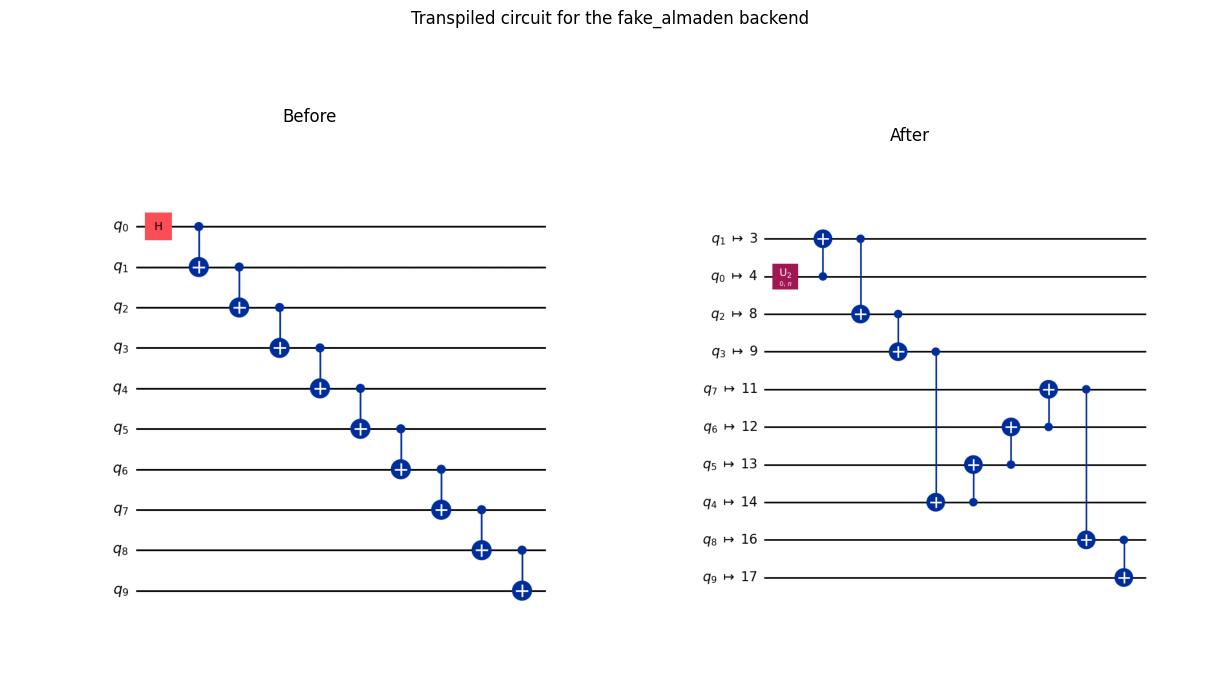

In [7]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import numpy as np

before = qc.draw('mpl')
after = circ.draw('mpl')

def fig_to_img(fig):
    canvas = FigureCanvas(fig)
    canvas.draw()
    buf = canvas.buffer_rgba()
    img = Image.fromarray(np.asarray(buf))
    return img

before = fig_to_img(before)
after = fig_to_img(after)

fig, ax = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f"Transpiled circuit for the {backend.backend_name} backend")
ax[0].imshow(before)
ax[1].imshow(after)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("Before")
ax[1].set_title("After")
plt.tight_layout(pad=0)
plt.show()

A few things have happened here. First, the `Hadamard` gate has been replaced with another unitary that is part of the ISA of the backend. Second, the circuit qubits have been mapped to the real qubits available in the backend. This has seemingly changed the layout of the circuit, but going through the interconnections, the topology has remained the same.

This circuit layout on its own does not yet give enough information to see what exactly is going on with the mapping to the backend. For that we also need to know how the qubits are laid out and how they connect to each other. For this we can query the backend and have it draw a nice picture of the layout topology.

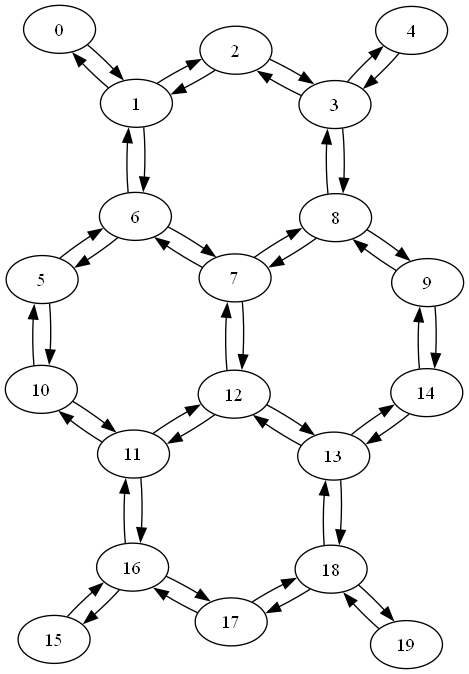

In [8]:
backend.coupling_map.draw()

Making a quick overview of how this mapping works, we get the following.

![Transpilation map example](./images/transpilation_map_example.png)

With the final qubit to backend mapping being:

![Mapping of qubits to backend](./images/mapping.png)

Now we can analyse the results.

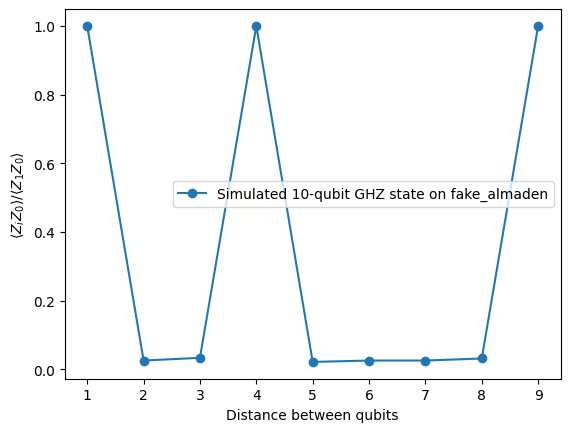

In [9]:
import matplotlib.pyplot as plt
distance = list(range(1, M))
values = result_est[0].data.evs
values = [v/values[0] for v in values]
plt.plot(distance, values, marker='o', label=f'Simulated {M}-qubit GHZ state on {backend.name}')
plt.xlabel("Distance between qubits")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

In [10]:
for i, j in zip(build_operators(M, M), result_est[0].data.evs):
    print(i.paulis, j)

['ZZIIIIIIII'] 1.0
['ZIZIIIIIII'] 0.026035129869366708
['ZIIZIIIIII'] 0.034035129869366715
['ZIIIZIIIII'] 1.0
['ZIIIIZIIII'] 0.022035129869366708
['ZIIIIIZIII'] 0.026035129869366708
['ZIIIIIIZII'] 0.026035129869366708
['ZIIIIIIIZI'] 0.03203512986936672
['ZIIIIIIIIZ'] 1.0


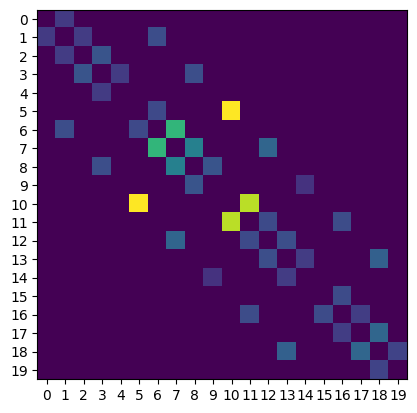

In [11]:
backend.properties().gate_error("cx", [3, 8])

errmap = np.ndarray(shape=(20, 20))

for q1 in range(20):
    for q2 in range(20):
        try:
            errmap[q1, q2] = backend.properties().gate_error("cx", [q1, q2])
        except:
            continue

plt.imshow(errmap)
plt.xticks(range(20))
plt.yticks(range(20))
plt.show()

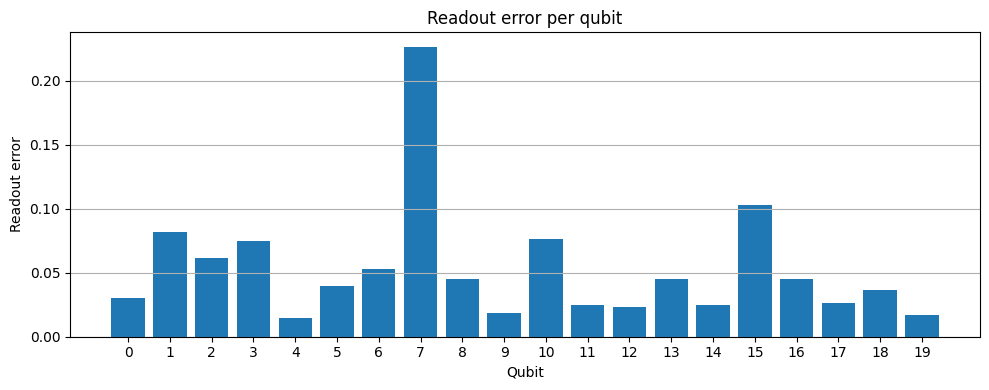

In [12]:
import matplotlib.pyplot as plt

readout_errors = []

# Extract average readout error for each qubit
for q in range(backend.configuration().num_qubits):
    prop = backend.properties()
    error = prop.readout_error(q)
    readout_errors.append(error)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(readout_errors)), readout_errors)
plt.xlabel("Qubit")
plt.ylabel("Readout error")
plt.title("Readout error per qubit")
plt.grid(axis='y')
plt.xticks(range(20))
plt.tight_layout()
plt.show()